In [1]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os


c:\Users\Scent\anaconda3\envs\CENT002\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001', 'engine_L001_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


119
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\engine_L001_result


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:


# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y = data['Engine Condition']

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング

# データセットを分割（train, test）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# NumPy配列をPyTorchのTensorに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # 分類用ラベル
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# TensorDatasetを作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaderを作成（バッチ処理用）
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
for batch_X, batch_y in train_dataloader:
    print("Batch X Shape:", batch_X.shape)
    print("Batch y Shape:", batch_y.shape)
    break


Batch X Shape: torch.Size([32, 6])
Batch y Shape: torch.Size([32])


In [5]:
'''class Encoder(nn.Module):#NL
    def __init__(self, input_dim, leverage, alpha=1.2):
        super(Encoder, self).__init__()
        self.leverage = leverage
        self.alpha = alpha

        output_dim = input_dim // leverage

        phase = torch.rand(output_dim, input_dim) * 2 * np.pi - np.pi
        #modulus = torch.ones(output_dim, kernel_in)
        modulus = torch.rand(output_dim, input_dim)

        # 複素数を生成 (r * exp(iθ) = r * (cos(θ) + i*sin(θ)))
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = True

    def forward(self, x):
        x = torch.exp(1j * self.alpha * x)
        x = torch.matmul(self.B, x.T).T
        x = torch.abs(x)**2
        return x'''

'class Encoder(nn.Module):#NL\n    def __init__(self, input_dim, leverage, alpha=1.2):\n        super(Encoder, self).__init__()\n        self.leverage = leverage\n        self.alpha = alpha\n\n        output_dim = input_dim // leverage\n\n        phase = torch.rand(output_dim, input_dim) * 2 * np.pi - np.pi\n        #modulus = torch.ones(output_dim, kernel_in)\n        modulus = torch.rand(output_dim, input_dim)\n\n        # 複素数を生成 (r * exp(iθ) = r * (cos(θ) + i*sin(θ)))\n        real_part = modulus * torch.cos(phase)\n        imag_part = modulus * torch.sin(phase)\n\n        self.B = torch.complex(real_part, imag_part).detach().to(device)\n        self.B.requires_grad = True\n\n    def forward(self, x):\n        x = torch.exp(1j * self.alpha * x)\n        x = torch.matmul(self.B, x.T).T\n        x = torch.abs(x)**2\n        return x'

In [6]:
class Encoder(nn.Module):#L
    def __init__(self, input_dim, leverage):
        super(Encoder, self).__init__()
        self.leverage = leverage

        self.B = nn.Parameter(torch.randn(int(input_dim/leverage), input_dim) * (1/np.sqrt(input_dim)))#.to(device)
        self.B.requires_grad = False

    
    def forward(self, x):
        x = torch.matmul(self.B, x.T).T
        return x

In [7]:
class PreBlock(nn.Module):

    def __init__(self, in_dim, out_dim, use_ln):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.relu = nn.LeakyReLU(inplace=True)
        self.use_ln = use_ln
        if use_ln:
            self.ln = nn.LayerNorm(out_dim)

    def forward(self, x):
        x = self.fc(x)       # (B, out_dim)
        if self.use_ln:
            x = self.ln(x)
        x = self.relu(x)
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out):
        super(Decoder, self).__init__()

        self.decoder_fc1 = nn.Linear(num_in, int((num_in + num_out) / 2))
        self.a1 = nn.Tanh()
        self.decoder_fc2 = nn.Linear(int((num_in + num_out) / 2), num_out)

    def forward(self, x):
        x = self.decoder_fc1(x)
        x = self.a1(x)
        x = self.decoder_fc2(x)
        return x

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, leverage):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_dim, leverage)
        self.decoder = Decoder(int(input_dim / leverage), input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [10]:

def TableCreater(batch_X, scaler, columns):

    # 有効数字の定義
    significant_digits = {
        'Engine rpm': 5,
        'Lub oil pressure': 8,
        'Fuel pressure': 8,
        'Coolant pressure': 8,
        'lub oil temp': 7,
        'Coolant temp': 7
    }

    # 有効数字を適用する関数
    def apply_significant_digits(value, digits):
        if value == 0:
            return 0
        else:
            return round(value, digits - int(np.floor(np.log10(abs(value)))) - 1)

    # スケールを元に戻す
    X_original = batch_X.numpy() * scaler.scale_ + scaler.mean_
    restored_df = pd.DataFrame(X_original, columns=columns)

    # 各特徴量に有効数字を適用
    for column, digits in significant_digits.items():
        if column in restored_df.columns:
            restored_df[column] = restored_df[column].apply(apply_significant_digits, args=(digits,))

    return restored_df.head(5).to_csv(sep='\t', index=False) # 最初の5行を返す


In [11]:
def plot_histograms(all_X, scaler, columns):

    # バッチデータを1つの配列に結合
    all_X_combined = np.vstack(all_X)

    # 標準化を元に戻す
    all_original_X = all_X_combined * scaler.scale_ + scaler.mean_

    # ヒストグラムを特徴量ごとに作成
    num_features = len(columns)  # 特徴量の数
    rows = (num_features + 2) // 3  # 3列2行で表示するための行数計算
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    # 各特徴量のヒストグラムをプロット
    for i, column in enumerate(columns):  # columns は特徴量名を使用
        row, col = divmod(i, 3)
        ax = axes[row, col]
        ax.hist(all_original_X[:, i], bins=20, edgecolor='k', alpha=0.7)
        ax.set_title(f'Histogram of {column}',fontsize=18)
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.5)

    # 空白のプロットを削除
    for j in range(num_features, rows * 3):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

In [12]:
for batch_X, batch_y in test_dataloader:
    processed_df = TableCreater(batch_X, scaler, data.columns.drop('Engine Condition'))
    break

# 結果の表示
print(processed_df)

Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
682.0	2.3916559	4.6171958	2.8489821	76.27242	69.88461
605.0	5.4668769	6.4243607	5.7275201	73.22268	74.90731
658.0	3.4342322	3.6808963	1.6787082	88.08992	78.70481
749.0	2.0946565	7.120927	1.6396704	77.66163	82.3867
676.0	3.538228	5.9564724	3.2253363	75.22635	67.15322



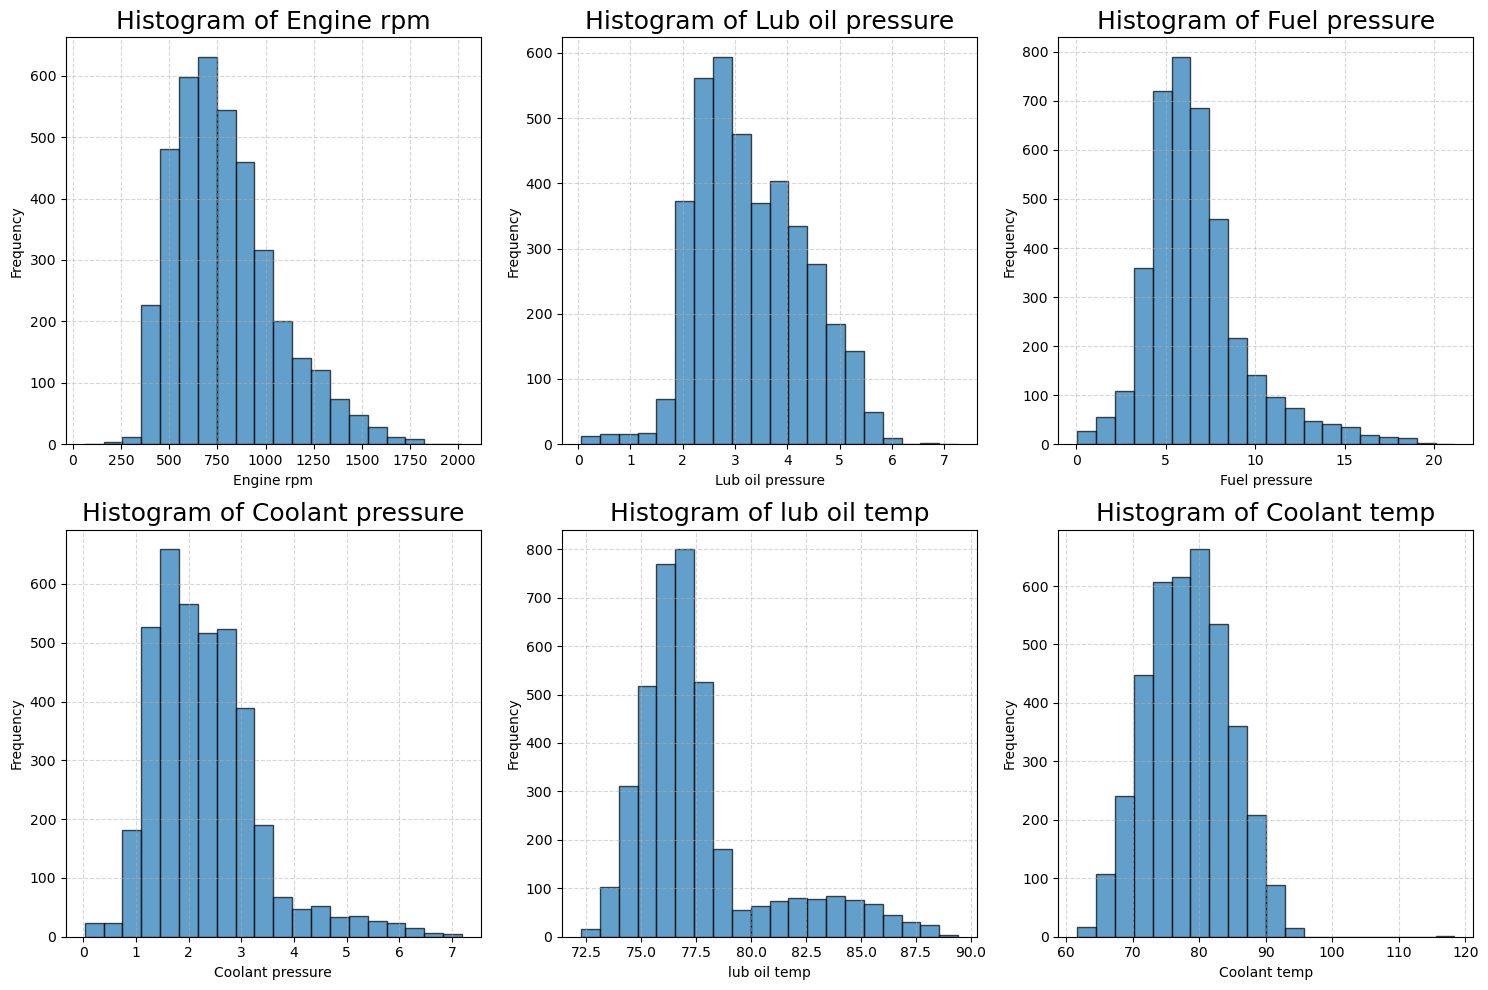

In [13]:
all_X = []
for batch_X, _ in test_dataloader:
    all_X.append(batch_X.numpy())

plot_histograms(all_X, scaler, data.columns.drop('Engine Condition'))

1/5th Time Epoch: 20/20

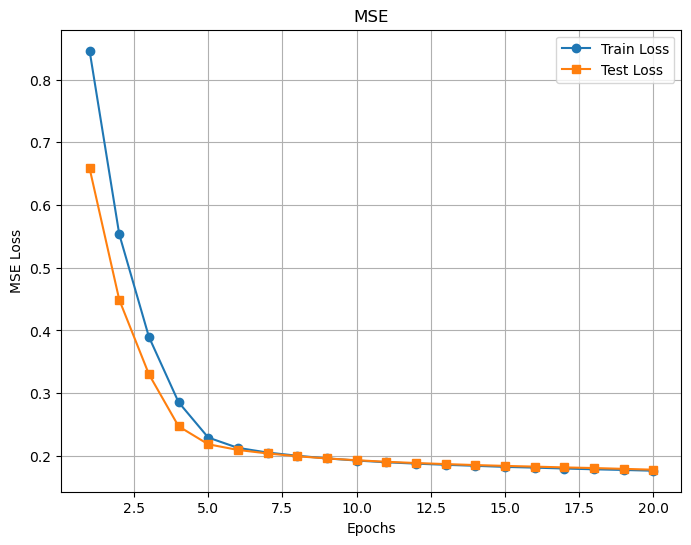

MSE 0.17787575473388037
Time 25.998672008514404
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
612.91	2.7386107	6.5752215	3.0509142	76.09801	69.49325
710.45	4.6898509	2.8612709	4.9951238	75.06327	76.64733
619.36	3.8324029	5.2467593	2.0536013	87.25122	78.29238
719.65	2.1870477	8.0798923	1.6650864	77.71553	82.64436
672.85	3.5052369	5.8067078	3.1676019	75.33653	66.89543



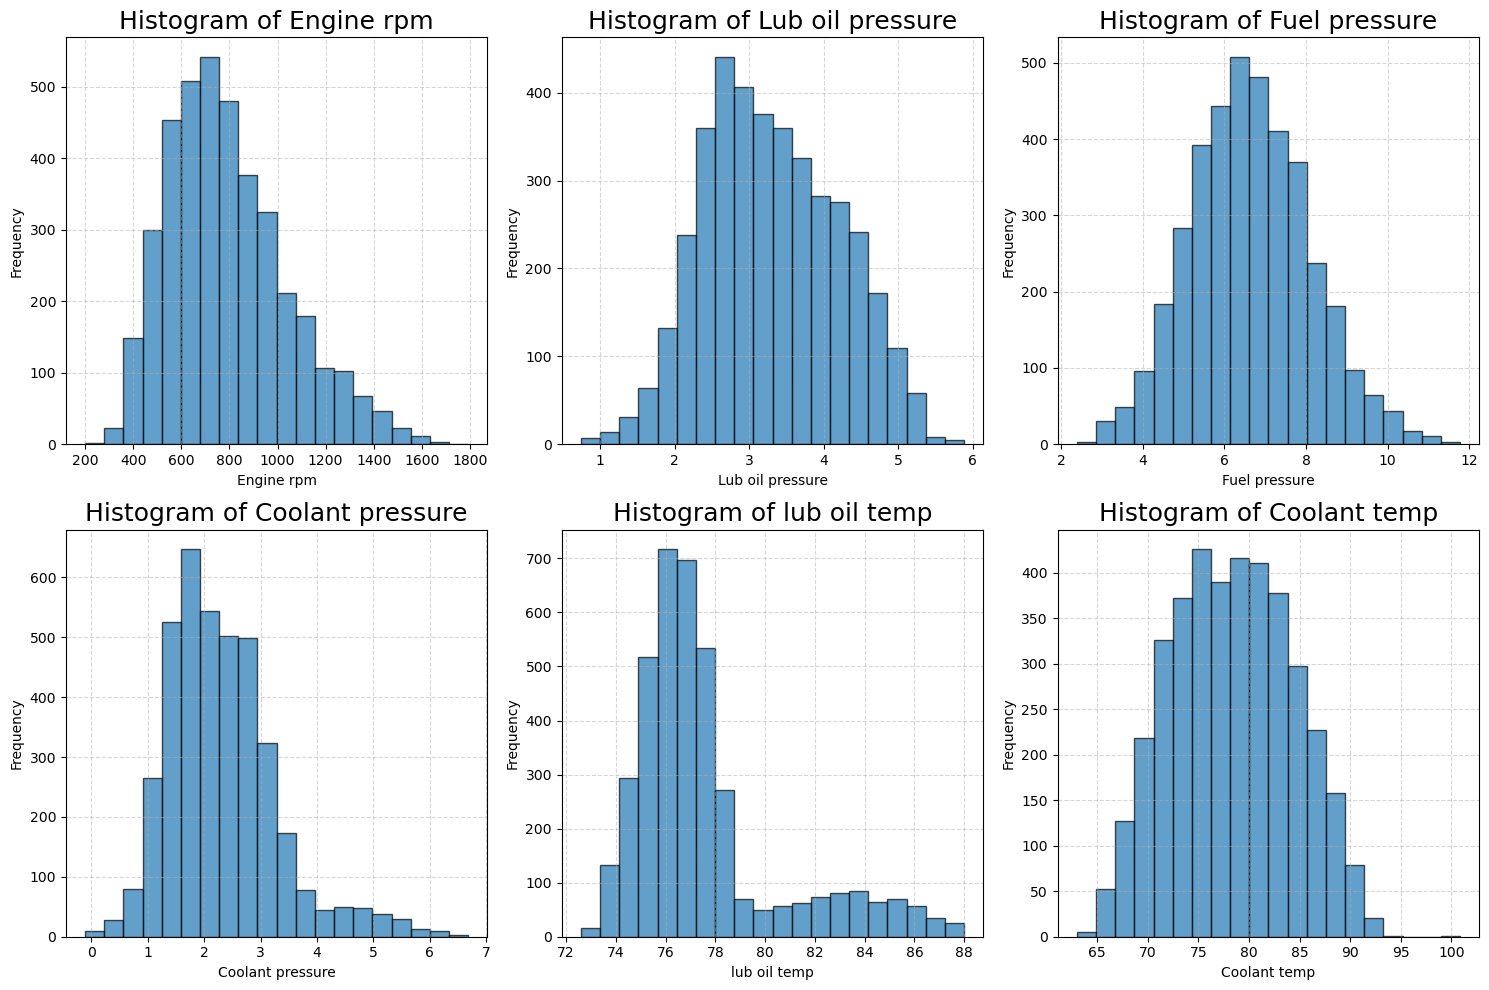

2/5th Time Epoch: 20/20

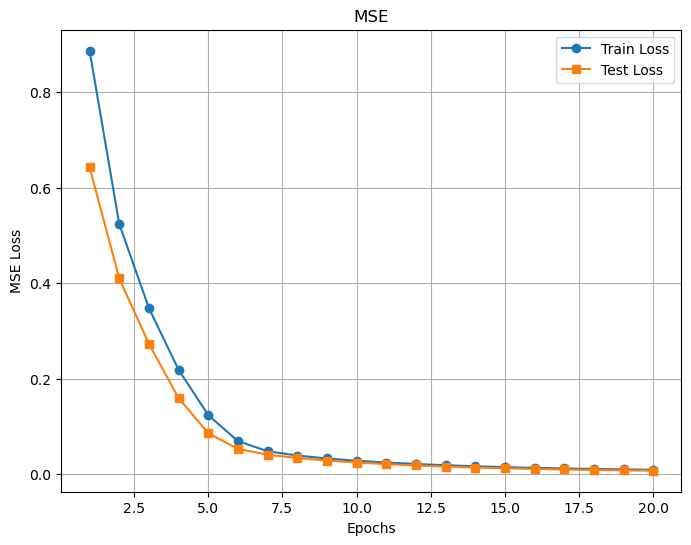

MSE 0.007324186749037022
Time 23.282689809799194
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
666.87	2.415448	4.6542563	2.9248609	76.33349	69.96065
622.86	5.3763279	7.4799628	5.4682884	73.9488	73.91953
666.31	3.4387983	3.8761078	1.8016313	88.26338	78.55495
746.99	2.0308064	7.1444141	1.5641384	77.65476	82.54504
676.34	3.5377625	6.1203617	3.2605448	74.87534	67.19179



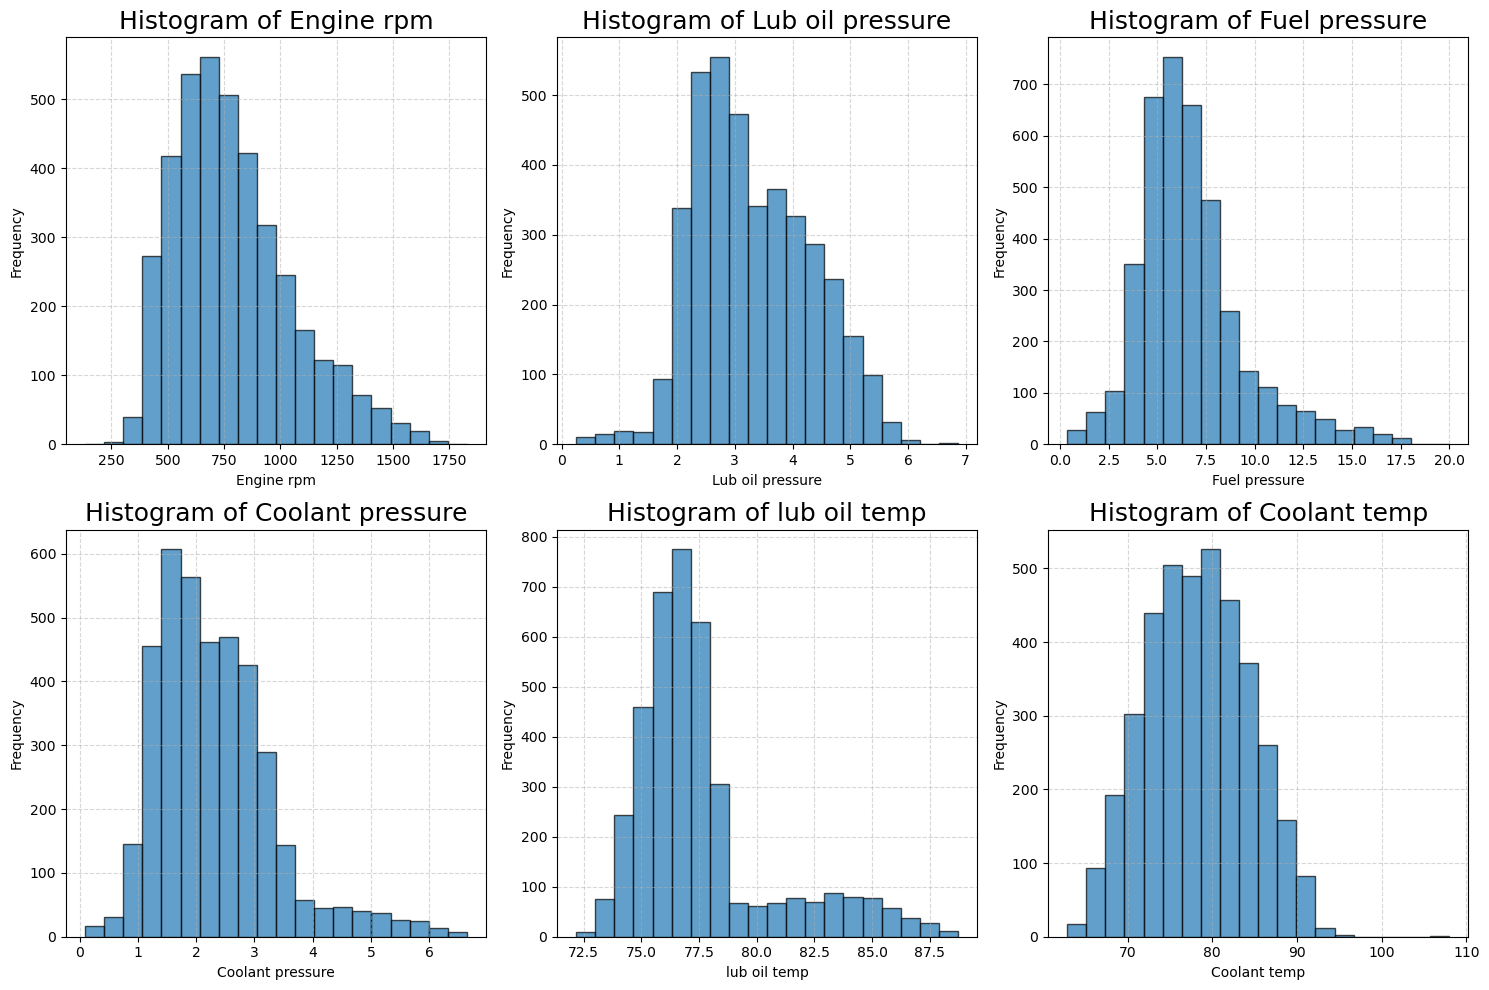

3/5th Time Epoch: 20/20

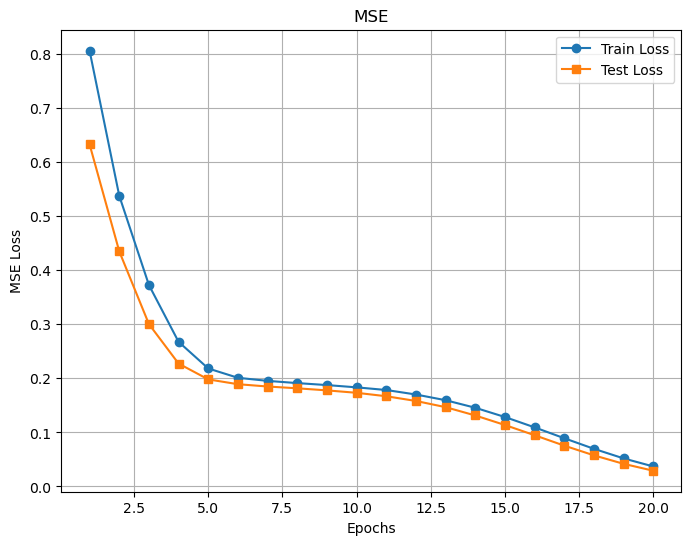

MSE 0.02911156342493567
Time 22.406737804412842
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
677.53	2.374104	4.8949913	2.9091426	76.4388	70.18839
656.17	5.343135	5.9367275	5.2942407	74.03739	75.11443
616.75	3.3285982	3.1570884	1.5033972	86.28298	78.16186
738.65	2.0655392	7.1428149	1.5669223	77.40035	82.47333
678.14	3.5752351	6.3277323	3.3134133	75.4688	67.31072



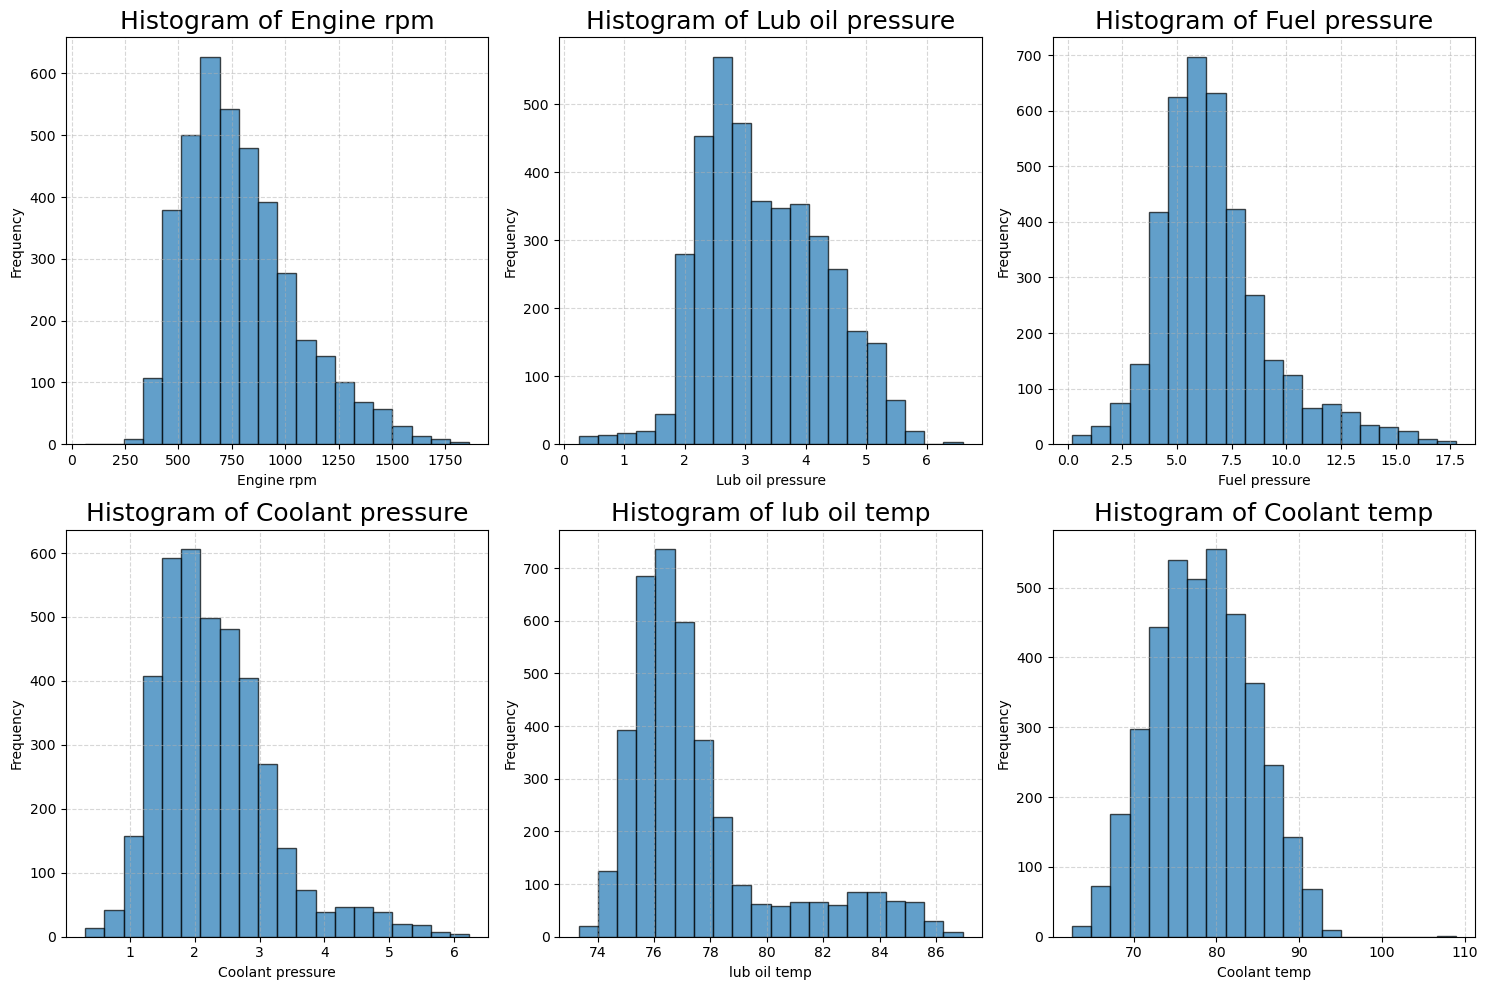

4/5th Time Epoch: 20/20

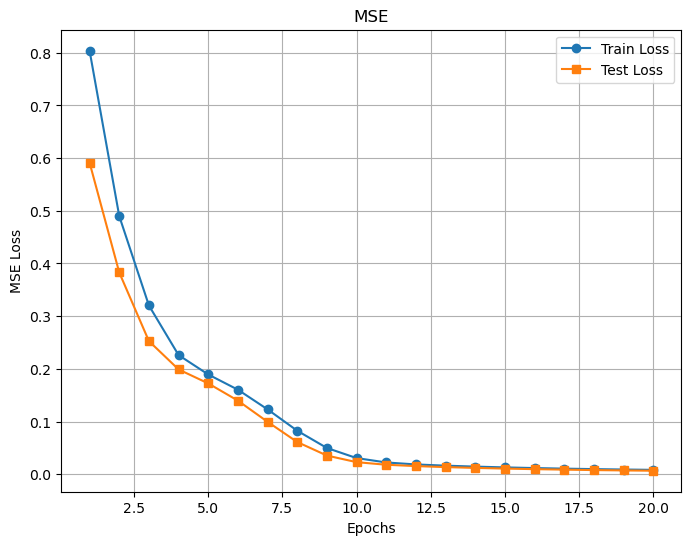

MSE 0.006588053821427066
Time 24.144784688949585
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
676.46	2.3574632	4.6005721	2.8549561	76.10684	69.76547
682.25	5.2458935	7.0418785	5.3492456	73.49134	75.11716
666.87	3.2838597	3.7162301	1.7525614	87.8583	78.75068
750.88	2.0259941	7.1543707	1.5715507	77.6891	82.5372
686.07	3.5310039	6.1383516	3.18745	75.13776	66.84849



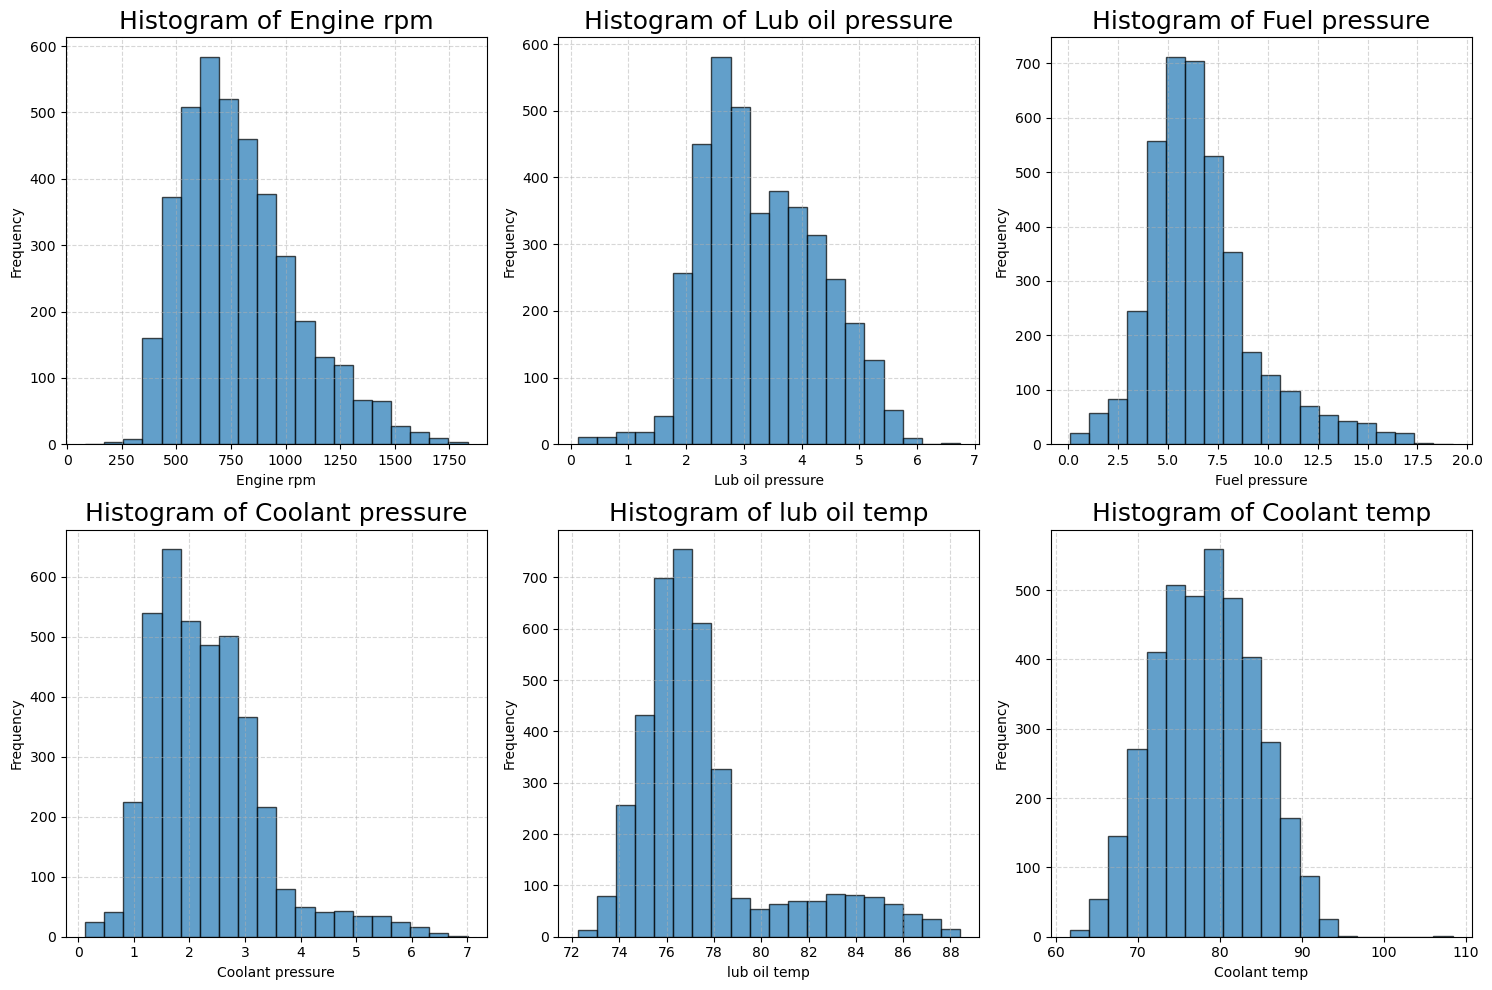

5/5th Time Epoch: 20/20

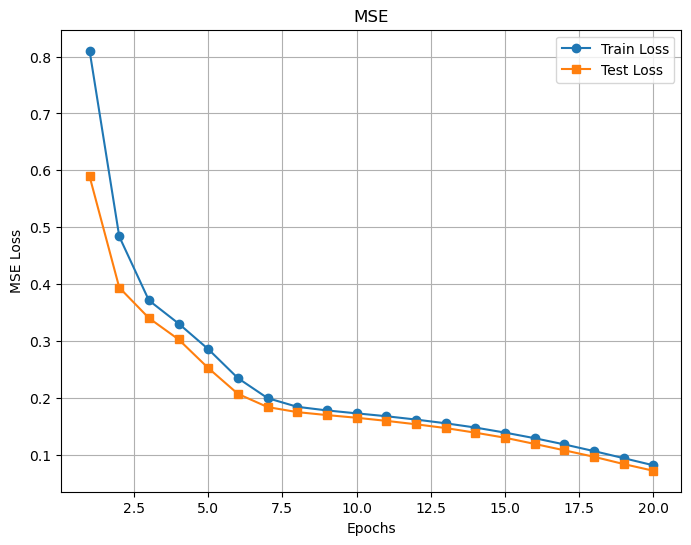

MSE 0.07212933937345094
Time 24.802603721618652
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
661.79	2.6311239	4.2127649	2.7680602	75.93552	69.45668
687.79	4.6375094	7.6766333	5.7455475	74.51188	74.00162
759.13	3.3544006	4.8284621	2.2107034	87.84178	79.18702
727.47	2.3841503	6.6087587	1.462878	77.27738	82.69064
675.48	3.4402981	5.9123404	3.2965284	75.24575	67.15725



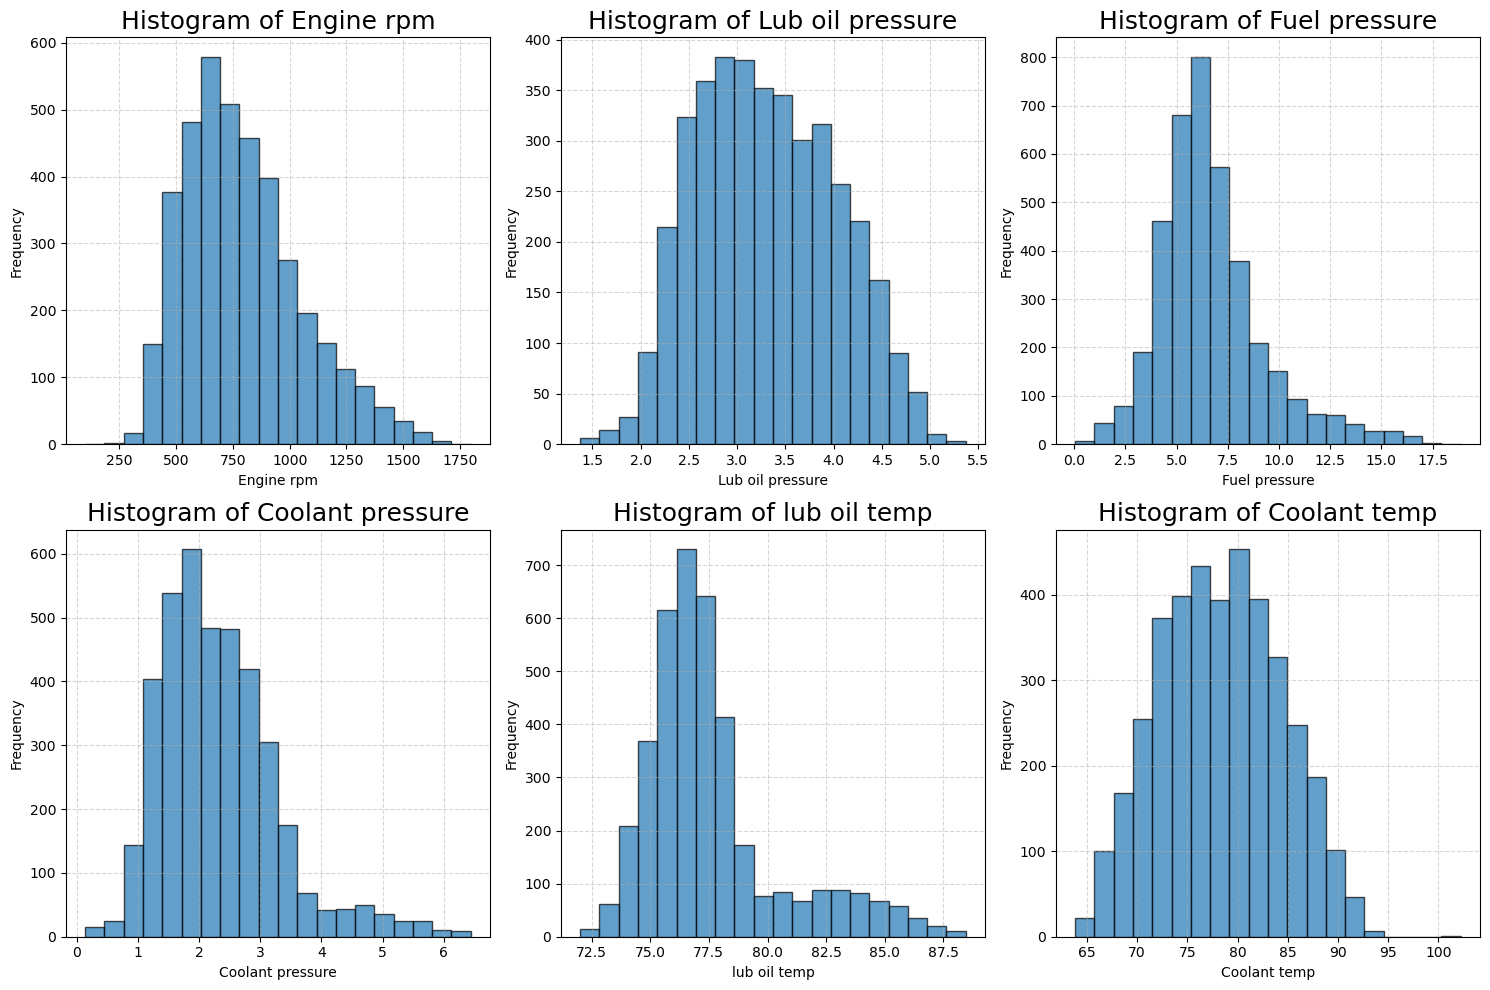

In [14]:
input_dim = X_train.shape[1]
leverage = 1  # 圧縮倍率
max_epochs = 20
lr = 0.0005 #学習率

num_try = 5 #

All_last_loss = []
All_loss_test = []
All_pro_time = []

for num_times in range(num_try): 
    model = AutoEncoder(input_dim, leverage).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss_train = 0
        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        start_time1 = time.time()
        for batch_X, _ in train_dataloader:
            batch_X = batch_X.to(device)

            reconstructed = model(batch_X)
            loss = criterion(reconstructed, batch_X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

        epoch_loss_train /= len(train_dataloader)
        loss_train_.append(epoch_loss_train)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        # テスト損失計算
        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():
            for batch_X, _ in test_dataloader:
                batch_X = batch_X.to(device)
                reconstructed = model(batch_X)
                loss = criterion(reconstructed, batch_X)
                epoch_loss_test += loss.item()

        epoch_loss_test /= len(test_dataloader)
        loss_test_.append(epoch_loss_test)

        if epoch == max_epochs-1:
            All_loss_test.append(loss_test_)
            All_pro_time.append(sum(pro_time_)) 
            Last_loss_test = loss_test_[-1]
            All_last_loss.append(Last_loss_test)

    # 収束グラフ
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_epochs+1), loss_train_, label='Train Loss', marker='o')
    plt.plot(range(1, max_epochs+1), loss_test_, label='Test Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('MSE',epoch_loss_test)
    print('Time',sum(pro_time_))

    all_test_X = []
    with torch.no_grad():  # 勾配計算を無効化
        for batch_X, _ in test_dataloader:
            batch_X = batch_X.to(device)
            reconstructed = model(batch_X).cpu().detach()  # モデルに通して復元
            all_test_X.append(reconstructed.numpy())

    with torch.no_grad():  # 勾配計算を無効化
        for batch_X, _ in test_dataloader:
            batch_X = batch_X.to(device)
            reconstructed = model(batch_X).cpu().detach()  # モデルに通して復元
            processed_df = TableCreater(reconstructed, scaler, data.columns.drop('Engine Condition'))
            print(processed_df)
            break

    plot_histograms(all_test_X, scaler, data.columns.drop('Engine Condition'))

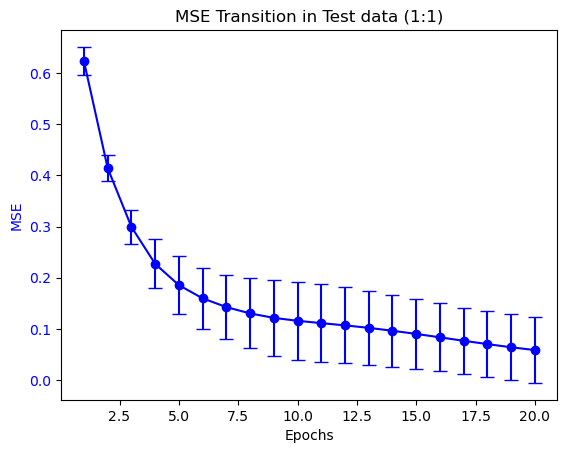

In [15]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)
file_name = '%d_MSE_errorbar.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

plt.show()

In [16]:

MSE_mean = np.mean(All_last_loss)
MSE_best = np.min(All_last_loss)
MSE_bestID = np.argmin(All_last_loss)+1
MSE_worst = np.max(All_last_loss)
MSE_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["MSE"],
    "Average": [MSE_mean],
    "Best ID": [MSE_bestID],
    "Best": [MSE_best],
    "Worst ID": [MSE_worstID],
    "Worst": [MSE_worst],
}

df = pd.DataFrame(data)

print(df)


         Average  Best ID      Best  Worst ID     Worst
0  MSE  0.058606        4  0.006588         1  0.177876


In [17]:
pro_time_mean = sum(All_pro_time)/len(All_pro_time)
data2 = {
    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
    "Processing Time": All_pro_time                # 各処理時間
}

df2 = pd.DataFrame(data2)
df2.loc[""] = ["Average", pro_time_mean]

print(df2)

     Index  Processing Time
0        1        25.998672
1        2        23.282690
2        3        22.406738
3        4        24.144785
4        5        24.802604
   Average        24.127098


In [18]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'engine_L001_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\texts
